In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we illustrate some of the most common statistical tests for testing null hypotheses in neuroscience data.

-- 
JM Murray, https://murraylab.uoregon.edu

# Z-test

This test isn't used in practice since it is only valid at large $n$, while the t-test below is valid for any $n$. Given normally distributed data $\{x_i\}$ with large $n$, the z-test tests the null hypothesis that the data came from a distribution with mean $\mu_0$. In what follows, we'll first do this test the long way by defining a function that computes the probability of the observed result under the null hypothesis based on taking lots of random draws from the null distribution. After that, we'll show that this result agrees with another, simpler approach to obtaining the area under the tails of the normal distribution, as well as (when $n$ is large) with a built-in method for computing the p-value using a t-test.

In [2]:
def p_ztest(x, mu0):
    '''
    This function numerically calculates the p-value for the null hypothesis
    mu = mu0 given an array of observations x according to a z-test.
    
    Parameters
    --
    x : a 1D array of data
    
    mu0 : the expected mean of the data under the null hypothesis
    
    Returns
    --
    The p-value, i.e. probability under the null hypothesis of the mean being
    a distance |mean(x) - mu0| or greater from mu0.
    '''
    x_bar = np.mean(x)
    x_stderr = np.std(x)/len(x)**0.5
    z_obs = (x_bar - mu0)/x_stderr
    
    n_samples = 100000
    count = 0
    for i in range(n_samples):
        z = np.random.randn()
        if abs(z) > abs(z_obs):
            count = count + 1
            
    return count/n_samples

0.05915
0.05991
0.05895
0.05971
0.05938


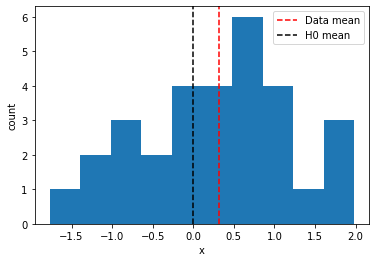

In [8]:
# Make up some data that doesn't come from the null-hypothesis distribution:
n = 30
x_test = 0.5 + 1.0*np.random.randn(n)

plt.hist(x_test);
plt.xlabel('x')
plt.ylabel('count')
plt.axvline(x=np.mean(x_test), color='r', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.legend(['Data mean', 'H0 mean'])

# Run the test 5 times to make sure the results are reproducible:
for i in range(5):
    print(p_ztest(x_test, 0))

The p-value answers the question: How likely is it that the data plotted above came from a normal distribution with mean $\mu_0$?

We can calculate the same thing in a slightly more convenient way by using SciPy to calculate the area under the tail of the normal distribution. 

In [9]:
from scipy import stats  # SciPy is a library of useful scientific functions, similar to NumPy

mu0 = 0
x_bar = np.mean(x_test)
x_stderr = np.std(x_test)/len(x_test)**0.5
z_obs = (x_bar - 0)/x_stderr

# The following calculates the "survival function" (i.e. area under one tail) for the standard normal distribution:
2*stats.norm.sf(abs(z_obs))

0.05924172662466432

# One-sample t-test

We can also calculate the p-value for the same data with a t-test, which is valid for both large and small $n$. This will, in general, give larger p-values than the z-test, though the values from the two tests should become closer as $n$ becomes larger. Note that, conveniently, we only have to provide the data when using the built-in function; it takes care of computing the mean and standard error for us.

In [10]:
# Compute the p-value according to the t-test on the same data:
print(stats.ttest_1samp(x_test, mu0))

Ttest_1sampResult(statistic=1.854688764610612, pvalue=0.07383450819540223)


# Paired t-test

If there is a one-to-one correspondence between the data points in two sets of data, a paired t-test is appropriate. For example, imagine we have $n=20$ mice, and we measure their performance on some task, so that $x^\text{before}_i$ is the performance of mouse $i$. Then we measure the performance of the same mice after performing some intervention, for example inactivating a particular brain area that is thought to be related to the task, and $x^\text{after}_i$ is the performance of mouse $i$ after the intervention. 

In [41]:
n = 20
x_before = 0 + np.random.randn(n)
x_after = x_before + 1 + np.random.randn(n)

print(stats.ttest_rel(x_before, x_after))

Ttest_relResult(statistic=-4.259709518929479, pvalue=0.00042353436638568187)


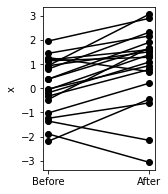

In [46]:
plt.figure(figsize=(2,3))

for i in range(n):
    plt.plot([0,1], [x_before[i], x_after[i]], '-ok')
    
plt.xticks([0,1], ['Before', 'After'])
plt.ylabel('x');

The way that the paired t-test works is by calculating the difference in the two sets of data and using an ordinary t-test to determine whether the mean of the resulting data set is significantly different from zero. If we calculate the p-value this way, we get the same result as above.

In [45]:
x_diff = x_after - x_before

print(stats.ttest_1samp(x_diff, 0))

Ttest_1sampResult(statistic=4.259709518929479, pvalue=0.00042353436638568187)


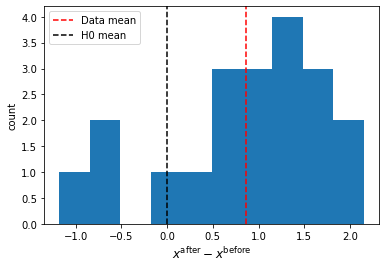

In [105]:
# Plot the difference between the two data sets:

plt.hist(x_diff);
plt.xlabel('$x^\mathrm{after} - x^\mathrm{before}$', fontsize=12)
plt.ylabel('count')
plt.axvline(x=np.mean(x_diff), color='r', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.legend(['Data mean', 'H0 mean'])


# Two-sample t-test

Now suppose that, rather than a single data set, we have two data sets, with measurements $x_i$ from the first data set and $y_i$ from the second. Unlike in the paired test, we assume here that the data sets are independent, so that there is no special relationship between pairs of points in the two data sets. We also don't need to assume that the data sets have the same numbers of observations in them.

The two-sample t-test allows us to test the null hypothesis that the distributions have the same mean, i.e. $H_0: \mu_x = \mu_y$. It works by computing a $t$ statistic on the difference $\bar{x} - \bar{y}$. It is appropriate for any value of $n$, and it assumes that the data are each drawn from normal distributions (possibly with distinct variances for the two distributions).

In [84]:
n = 30
x = np.random.randn(n)
y = 0.5 + np.random.randn(n)

print(stats.ttest_ind(x,y))


Ttest_indResult(statistic=-3.070989493718506, pvalue=0.0032450308960496116)


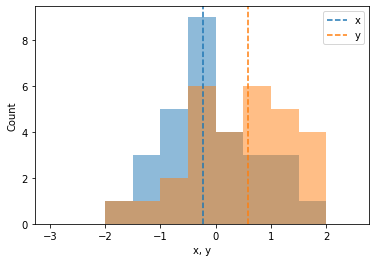

In [85]:
plt.hist(x, bins=np.arange(-3,3,0.5), alpha=0.5)
plt.hist(y, bins=np.arange(-3,3,0.5), alpha=0.5)
plt.xlabel('x, y')
plt.ylabel('Count')
plt.axvline(x=np.mean(x), color='tab:blue', linestyle='--')
plt.axvline(x=np.mean(y), color='tab:orange', linestyle='--')
plt.legend(['x','y'])

If the variances of the two distributions are unequal (rule of thumb: this only matters if they differ by more than a factor of two), we can give an extra argument to the above test. This version is known as Welch's t-test.

In [98]:
n = 30
x = np.random.randn(n)
y = 2.0 + 3.0*np.random.randn(n)

print(stats.ttest_ind(x,y, equal_var=False))


Ttest_indResult(statistic=-3.7672137446142986, pvalue=0.0006827280526312336)


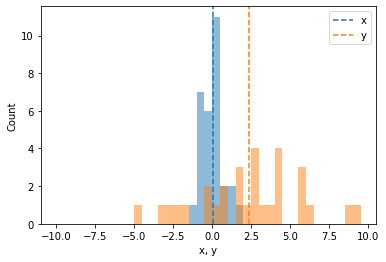

In [99]:
plt.hist(x, bins=np.arange(-10,10,0.5), alpha=0.5)
plt.hist(y, bins=np.arange(-10,10,0.5), alpha=0.5)
plt.xlabel('x, y')
plt.ylabel('Count')
plt.axvline(x=np.mean(x), color='tab:blue', linestyle='--')
plt.axvline(x=np.mean(y), color='tab:orange', linestyle='--')
plt.legend(['x','y'])

# Wilcoxon rank-sums test for non-normal data

All of the statistical tests above assumed that the data came from a normal distribution, i.e. $x_i \sim \mathcal{N}(\mu, \sigma^2)$. If this is not the case, the Wilcoxon rank-sums test provides an appropriate statistical test for testing the whether two distributions are distinct from one another. As for the two-sample t-test described above, we assume that the two samples are statistically independent (i.e. not paired observations of the same individuals, as in the paired t-test).

Given two sets of data, this test is designed to test the null hypothesis $H_0: \mu_x = \mu_y$, without making any particular assumption about what distributions the two sets of data are drawn from. It is based on the following idea. Imagine that we have two data sets, $X$ and $Y$, and sort all of the data points (including both data sets) from smallest to largest. If $X$ and $Y$ come from the same distribution, then they will be interspersed roughly evenly in this ordered list. If they come from different distributions, though, then most of the small values in the list will come from $X$ and most of the large values will come from $Y$, or vice versa. The Wilcoxon rank-sums test quantifies how unlikely the observed ordering would be based on the null hypothesis that the two distributions are the same. Note that it depends only on the ordering of the data, without making any assumptions about what sort of distribution the data come from.

An example of where this might be useful is for the firing rates of neurons, which tend to have "heavy-tailed" distributions (often modeled as a "log-normal" distribution, as done below). In the example shown below, we can imagine that $x_i$ is the firing rate of a particular neuron in trial $i$ before some intervention (e.g. inactivating an adjacent brain area), and $y_i$ is the firing rate of the same neuron in trial $i$ after the intervention. Can we conclude that the firing rate changes significantly following the intervention?

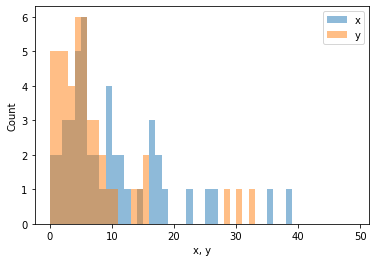

In [101]:
n = 50
x = np.random.lognormal(mean=2, sigma=1, size=n)
y = np.random.lognormal(mean=1.5, sigma=1, size=n)

# Plot the two histograms on top of one another; notice the heavy tails extending to large values of x and y:
plt.hist(x, bins=np.arange(50), alpha=0.5)
plt.hist(y, bins=np.arange(50), alpha=0.5)
plt.xlabel('x, y')
plt.ylabel('Count')
plt.legend(['x','y'])

In [102]:
stats.ranksums(x,y)

RanksumsResult(statistic=2.5369257141682175, pvalue=0.011183068138372646)

Because this test is based only on the ordering of the entries, we can "warp" or rescale the variables without changing the result, as long as the transformation function is monotonically increasing and the same function is applied to both sets of data. For example, we can take the square root of both sets of data and still get the same p-value:

RanksumsResult(statistic=2.5369257141682175, pvalue=0.011183068138372646)

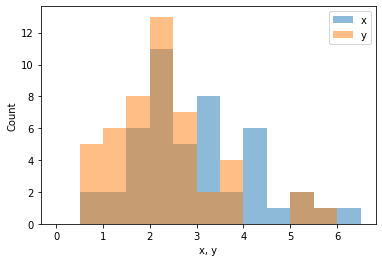

In [111]:
x_sqrt = x**0.5
y_sqrt = y**0.5

# Plot the two histograms on top of one another; notice the heavy tails extending to large values of x and y:
plt.hist(x_sqrt, bins=np.arange(0,7,0.5), alpha=0.5)
plt.hist(y_sqrt, bins=np.arange(0,7,0.5), alpha=0.5)
plt.xlabel('x, y')
plt.ylabel('Count')
plt.legend(['x','y'])

print(stats.ranksums(x,y))  # Note this gives the same value as above